In [57]:
!pip install mpi4py

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from PIL import Image
from mpi4py import MPI

In [80]:
!pip install -U memory_profiler
from memory_profiler import profile

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=7f38bf2bebcbdc33587a3b024f3da9c2ed090c2b7059f38898da66889914ac6b
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
Successfully built memory-profiler


# 1. Find Some Good Anime Meme

In [59]:
!wget https://www.meme-arsenal.com/memes/6344bc72c76ca261f5e4af49d78fc24b.jpg

--2021-12-05 19:32:43--  https://www.meme-arsenal.com/memes/6344bc72c76ca261f5e4af49d78fc24b.jpg
Resolving www.meme-arsenal.com (www.meme-arsenal.com)... 172.67.74.167, 104.26.0.240, 104.26.1.240, ...
Connecting to www.meme-arsenal.com (www.meme-arsenal.com)|172.67.74.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105193 (103K) [image/jpeg]
Saving to: ‘6344bc72c76ca261f5e4af49d78fc24b.jpg.1’

6344bc72c76ca261f5e 100%[===================>] 102.73K  --.-KB/s    in 0.01s   

2021-12-05 19:32:43 (8.95 MB/s) - ‘6344bc72c76ca261f5e4af49d78fc24b.jpg.1’ saved [105193/105193]



In [60]:
name = '6344bc72c76ca261f5e4af49d78fc24b.jpg'
image = np.array(Image.open(name))

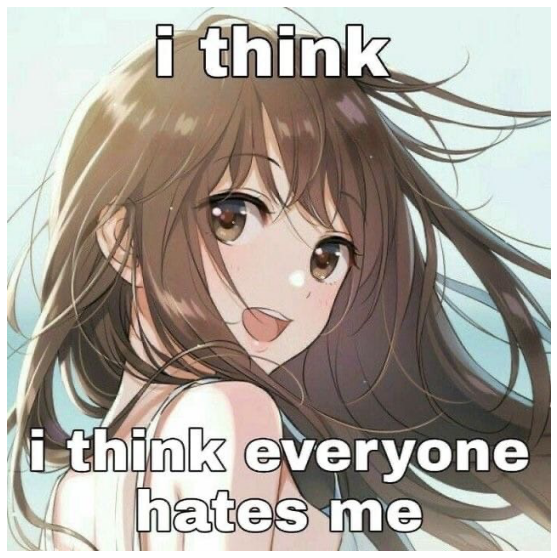

In [61]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

plt.axis('off')
plt.show()

# 2. Implement Parallel Vertical Shifting using `mpi4py`

In [81]:
%%writefile solution-lab-8.py

import numpy as np
import pickle
import sys

from PIL import Image
from mpi4py import MPI
from memory_profiler import profile

def shift_image(image):
    image = image.copy()

    n_shifts = image.shape[0]
    images = []

    for _ in range(n_shifts):
        image = np.roll(image, shift=1, axis=0)
        images.append(image.copy())

    return np.array(images)

@profile
def perform_parallel_shifting():
    ### setup mpi environment

    comm = MPI.COMM_WORLD
    start = MPI.Wtime()

    rank = comm.Get_rank()
    size = comm.Get_size()
    root = 0

    ### define parameters for shifting

    name = '6344bc72c76ca261f5e4af49d78fc24b.jpg' if len(sys.argv) < 2 else sys.argv[1]

    if rank == root:
        image = np.array(Image.open(name))

        width_part = int(image.shape[1] / size)
        images_stacked = [image[:, int(i * width_part):int((i + 1) * width_part)] for i in range(size)]
    else:
        images_stacked = None

    ### assign integration parts between processes

    image_part = comm.scatter(images_stacked, root=root)
    # let us denote H as height, W as width, S as number of processes, C as number of channels and N as number of shifts
    # then the shape of `image_part` is H x W / S x C

    ### perform shifting in every process

    image_parts_shifted = shift_image(image_part)
    # and the shape of `shifted_image_parts` is N x H x W / S x C

    n_shifts, height, width_part, n_channels = image_parts_shifted.shape
    image_parts_shifted_stacked = np.empty((size, n_shifts, height, width_part, n_channels), dtype=np.uint8) if rank == root else None

    comm.Gatherv(image_parts_shifted, image_parts_shifted_stacked, root=root)
    end = MPI.Wtime()

    if rank == root:
        image_parts_shifted_stacked = np.concatenate(list(image_parts_shifted_stacked), axis=2)

        with open(f'images-{size}.pkl', 'wb') as f:
            pickle.dump(image_parts_shifted_stacked, f)

        with open(f'time-{size}.pkl', 'wb') as f:
            pickle.dump(end - start, f)

perform_parallel_shifting()

Overwriting solution-lab-8.py


In [82]:
n_processes = 4
!mpirun --allow-run-as-root -n {n_processes} python3 -m memory_profiler solution-lab-8.py > memory-{n_processes}.txt

In [83]:
!cat memory-{n_processes}.txt

Filename: solution-lab-8.py

Line #    Mem usage    Increment  Occurences   Line Contents
    22     64.3 MiB     64.3 MiB           1   @profile
    23                                         def perform_parallel_shifting():
    24                                             ### setup mpi environment
    25                                         
    26     64.3 MiB      0.0 MiB           1       comm = MPI.COMM_WORLD
    27     64.3 MiB      0.0 MiB           1       start = MPI.Wtime()
    28                                         
    29     64.3 MiB      0.0 MiB           1       rank = comm.Get_rank()
    30     64.3 MiB      0.0 MiB           1       size = comm.Get_size()
    31     64.3 MiB      0.0 MiB           1       root = 0
    32                                         
    33                                             ### define parameters for shifting
    34                                         
    35     64.3 MiB      0.0 MiB           1       name = '6344bc72

In [75]:
with open(f'images-{n_processes}.pkl', 'rb') as f:
    images = pickle.load(f)

In [76]:
images.shape

(640, 640, 640, 3)

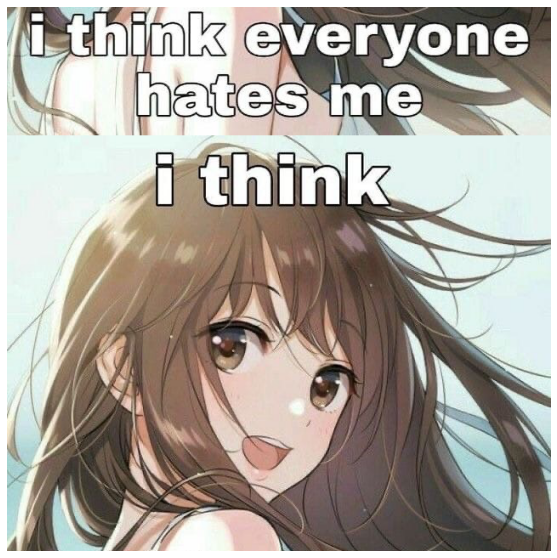

In [77]:
plt.figure(figsize=(10, 10))
plt.imshow(images[150])

plt.axis('off')
plt.show()

# 3. Plot Speedup for Different Number of Processes

In [88]:
nn = np.logspace(0, 3, base=2, num=4).astype(np.int)

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 -m memory_profiler solution-lab-8.py > memory-{n_processes}.txt

In [89]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

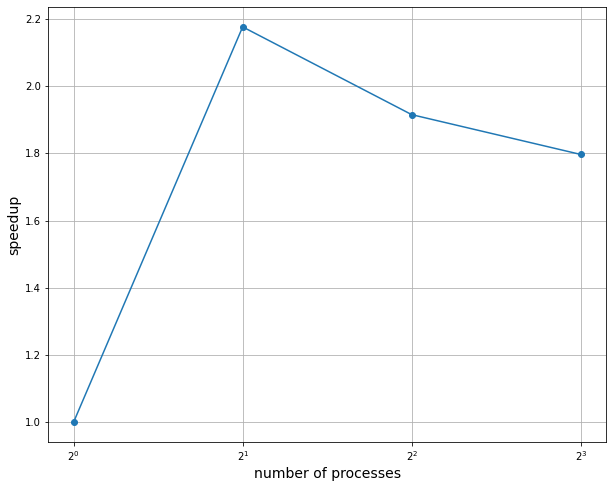

In [90]:
plt.figure(figsize=(10, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('speedup', fontsize=14)

plt.xscale('log', basex=2)
plt.grid()
plt.show()

# 4. Create Gif

In [91]:
import os
import imageio

from tqdm import tqdm

In [93]:
folder = f'./picture-shift/'
if not os.path.exists(folder):
    os.mkdir(folder)

for i in tqdm(range(len(images))):
    plt.figure(figsize=(10, 10))
    plt.imshow(images[i])

    plt.axis('off')
    plt.savefig(folder + f'step-{i}.jpg', bbox_inches='tight')
    plt.close('all')

filenames = list(filename for filename in os.listdir(folder) if filename.endswith('jpg'))
filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0].split('-')[-1]))

100%|██████████| 160/160 [00:26<00:00,  5.97it/s]


In [94]:
images = []
skip = 4

for i, filename in enumerate(filenames):
    if not i % skip:
        images.append(imageio.imread(folder + filename))

imageio.mimsave(folder + 'picture-shift.gif', images)

In [18]:
!ls picture-shift/

picture-shift-final.gif


In [21]:
from IPython.display import HTML
HTML('<img src="./picture-shift/picture-shift-final.gif">')

# 5. Plot Memory Consumption

In [97]:
!cat memory-1.txt

Filename: solution-lab-8.py

Line #    Mem usage    Increment  Occurences   Line Contents
    22     63.0 MiB     63.0 MiB           1   @profile
    23                                         def perform_parallel_shifting():
    24                                             ### setup mpi environment
    25                                         
    26     63.0 MiB      0.0 MiB           1       comm = MPI.COMM_WORLD
    27     63.0 MiB      0.0 MiB           1       start = MPI.Wtime()
    28                                         
    29     63.0 MiB      0.0 MiB           1       rank = comm.Get_rank()
    30     63.0 MiB      0.0 MiB           1       size = comm.Get_size()
    31     63.0 MiB      0.0 MiB           1       root = 0
    32                                         
    33                                             ### define parameters for shifting
    34                                         
    35     63.0 MiB      0.0 MiB           1       name = '6344bc72

In [98]:
!cat memory-2.txt

Filename: solution-lab-8.py

Line #    Mem usage    Increment  Occurences   Line Contents
    22     63.2 MiB     63.2 MiB           1   @profile
    23                                         def perform_parallel_shifting():
    24                                             ### setup mpi environment
    25                                         
    26     63.2 MiB      0.0 MiB           1       comm = MPI.COMM_WORLD
    27     63.2 MiB      0.0 MiB           1       start = MPI.Wtime()
    28                                         
    29     63.2 MiB      0.0 MiB           1       rank = comm.Get_rank()
    30     63.2 MiB      0.0 MiB           1       size = comm.Get_size()
    31     63.2 MiB      0.0 MiB           1       root = 0
    32                                         
    33                                             ### define parameters for shifting
    34                                         
    35     63.2 MiB      0.0 MiB           1       name = '6344bc72

In [99]:
!cat memory-4.txt

Filename: solution-lab-8.py

Line #    Mem usage    Increment  Occurences   Line Contents
    22     64.0 MiB     64.0 MiB           1   @profile
    23                                         def perform_parallel_shifting():
    24                                             ### setup mpi environment
    25                                         
    26     64.0 MiB      0.0 MiB           1       comm = MPI.COMM_WORLD
    27     64.0 MiB      0.0 MiB           1       start = MPI.Wtime()
    28                                         
    29     64.0 MiB      0.0 MiB           1       rank = comm.Get_rank()
    30     64.0 MiB      0.0 MiB           1       size = comm.Get_size()
    31     64.0 MiB      0.0 MiB           1       root = 0
    32                                         
    33                                             ### define parameters for shifting
    34                                         
    35     64.0 MiB      0.0 MiB           1       name = '6344bc72

In [100]:
!cat memory-8.txt

Filename: solution-lab-8.py

Line #    Mem usage    Increment  Occurences   Line Contents
    22     64.1 MiB     64.1 MiB           1   @profile
    23                                         def perform_parallel_shifting():
    24                                             ### setup mpi environment
    25                                         
    26     64.1 MiB      0.0 MiB           1       comm = MPI.COMM_WORLD
    27     64.1 MiB      0.0 MiB           1       start = MPI.Wtime()
    28                                         
    29     64.1 MiB      0.0 MiB           1       rank = comm.Get_rank()
    30     64.1 MiB      0.0 MiB           1       size = comm.Get_size()
    31     64.1 MiB      0.0 MiB           1       root = 0
    32                                         
    33                                             ### define parameters for shifting
    34                                         
    35     64.1 MiB      0.0 MiB           1       name = '6344bc72

In [101]:
memory_consumption = [3073.0, 815.9 + 3072.7, 440.6 * 3 + 2696.2, 253.5 * 7 + 2510.4]

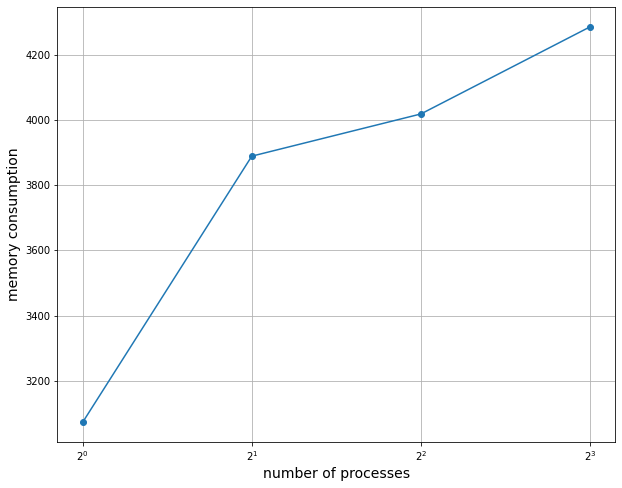

In [102]:
plt.figure(figsize=(10, 8))
plt.plot(nn, memory_consumption, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('memory consumption', fontsize=14)

plt.xscale('log', basex=2)
plt.grid()
plt.show()

Memory consumption per one process (including the root process) is decreasing